<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/web-design-gan/WebDesign_32x32_DCGAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WebDesign DCGAN
### Generating Web Design inspiration using DCGAN (in Keras)
-----
This is a very first attempt to generate a webdesign using GAN.  

Due to the limited dataset of 6K web designs scraped from internet, I start with a small model to generate 32x32 images.

If the model shows promise at this small scale, I would try to increase the output images size with bigger models.


In [0]:
!unzip -q dribbble_07_05_2020_cropped_resized_32x32.zip

In [0]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Dense, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
# input dimensions
img_width = 32
img_height = 32
img_channel = 3

img_size = img_width * img_height * img_channel
img_shape = (img_width, img_height, img_channel)

batch_size = 64
z_dim = 100

In [6]:
# create a data generator
datagen = ImageDataGenerator()
# load and iterate training dataset
train_it = datagen.flow_from_directory('dribbble_07_05_2020_cropped_resized_32x32',
                                       target_size=(img_width,img_height), 
                                       batch_size=batch_size)

Found 6708 images belonging to 89 classes.


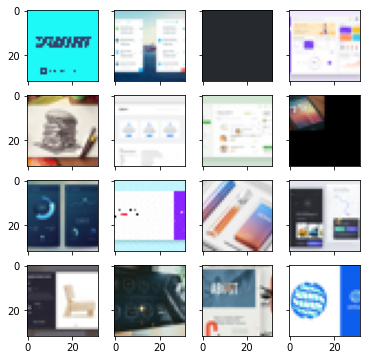

In [8]:
num_cols = 4
num_rows = 4

train_iter = iter(train_it)
images, _ = next(train_iter)
images = images/ 255
images = images * 2 -1
images = (images + 1) * 0.5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6,6), sharex=True, sharey=True)

cnt = 0

for r in range(num_rows):
  for c in range(num_cols):
    ax[r][c].imshow(images[cnt])
    cnt += 1


In [0]:
# Generator
def build_generator(z_dim=z_dim):
  model = Sequential()
  
  # 100 -> 8*8*256
  model.add(Dense(8*8*256,input_dim=z_dim))
  model.add(Reshape((8,8,256)))

  # 8*8*256 -> 16*16*128
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 16*16*128 -> 16*16*64
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 16*16*64 -> 32*32*3
  model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))

  return model

In [0]:
# Discriminator

def build_discriminator(img_shape=img_shape, img_size=img_size):
  model = Sequential()
  
  # 32*32*3 -> 16*16*32
  model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.1))

  # 16*16*32 -> 16*16*64
  model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 16*16*64 -> 8*8*128
  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 8*8*128 -> 3*3*256
  model.add(Flatten())
  
  # 3*3*128 -> 1
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  return model

In [0]:
# Full GAN model

def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [0]:
# Build and compile GAN model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator()
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [0]:
# Training loop

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, print_every, sample_every):

  # (x_train, _), (_,_) = mnist.load_data()
  # x_train = x_train / 255                   # range 0 to 1
  # x_train = x_train*2 - 1                   # change to range -1 to 1
  # x_train = np.expand_dims(x_train, axis=3)

  real_labels = np.ones((batch_size,1))
  fake_labels = np.zeros((batch_size,1))

  iteration = 0

  for images, _ in train_it:

    if len(images) == batch_size :
      # Take a batch of real images
      x = images / 255                   # range 0 to 1
      x = x*2 - 1                   # change to range -1 to 1
    
      # idx = np.random.randint(0, x_train.shape[0], batch_size)
      # x = x_train[idx]


      # Take a batch of random noise vectors
      z = np.random.normal(0,1,(batch_size, z_dim))

      # Generate a batch of fake images
      x_star = generator.predict(z)

      # Calculate D loss on real images 
      d_real_loss = discriminator.train_on_batch(x, real_labels)

      # Calculate D loss on fake image
      d_fake_loss = discriminator.train_on_batch(x_star, fake_labels)

      # Calculate total D loss
      d_loss, accuracy = np.add(d_real_loss, d_fake_loss) *0.5

      #**********************************#
      #         Train Generator          #
      #**********************************#

      # Take a batch of random noise vectors
      z = np.random.normal(0,1,(batch_size, z_dim))

      # Generate a batch of fake images
      x_star = generator.predict(z)

      g_loss = gan.train_on_batch(z, real_labels)

      #**********************************#
      #       Iteration Metrics          #
      #**********************************#
      iteration_checkpoints.append(iteration+1)
      losses.append((d_loss, g_loss))

      #**********************************#
      #     Aggregated Step Metrics      #
      #**********************************#
      if (iteration+1) % print_every == 0:
        print("%d [D Loss: %f] [G Loss: %f]" %(iteration+1, d_loss, g_loss))
      if (iteration+1) % sample_every == 0:
        sample_digits(generator)
      
      
      if iteration == iterations:
        break
      else:
        iteration += 1


In [0]:
# Method to show sample images from generator

def sample_digits(generator, num_rows=4, num_cols=4, zoom_level=1):
  z = np.random.randn(num_rows * num_cols, z_dim)
  imgs = generator.predict(z)
  imgs = (imgs + 1) * 0.5
  fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*zoom_level,num_rows*zoom_level), sharex=True, sharey=True)
  
  cnt = 0
  
  for r in range(num_rows):
    for c in range(num_cols):
      ax[r][c].imshow(imgs[cnt, :, :, :])
      cnt += 1

### Train DCGAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D Loss: 0.009695] [G Loss: 5.752326]
2000 [D Loss: 0.101741] [G Loss: 7.929806]
3000 [D Loss: 0.047608] [G Loss: 4.976843]
4000 [D Loss: 0.008647] [G Loss: 5.892834]
5000 [D Loss: 0.054860] [G Loss: 5.949911]
6000 [D Loss: 0.023843] [G Loss: 7.668999]
7000 [D Loss: 0.027881] [G Loss: 7.083529]
8000 [D Loss: 0.030754] [G Loss: 6.407897]
9000 [D Loss: 0.002878] [G Loss: 8.571674]
10000 [D Loss: 0.008713] [G Loss: 9.300688]
11000 [D Loss: 0.012474] [G Loss: 5.665745]
12000 [D Loss: 0.000816] [G Loss: 9.955328]
13000 [D Loss: 0.003888] [G Loss: 9.999192]
14000 [D Loss: 0.001107] [G Loss: 8.028112]
15000 [D Loss: 0.002910] [G Loss: 8.104784]
16000 [D Loss: 0.053656] [G Loss: 9.552926]
17000 [D Loss: 0.004806] [G Loss: 8.512280]
18000 [D Loss: 0.001813] [G Loss: 9.854502]
19000 [D Loss: 0.003149] [G Loss: 8.811362]
20000 [D Loss: 0.002821] [G Loss: 8.905461]
21000 [D Loss: 0.011211] [G Loss: 11.662085]
22000 [D Loss: 0.088040] [G Loss: 7.036319]
23000 [D Loss: 0.287894] [G Loss: 8.4361

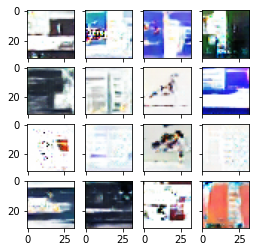

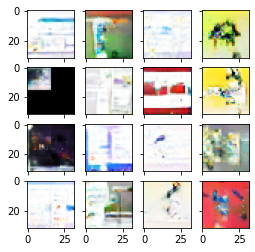

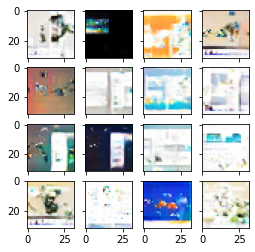

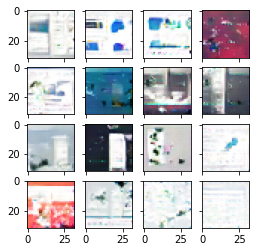

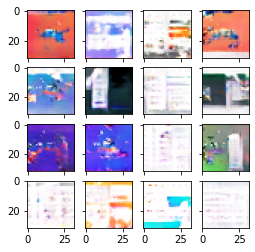

In [19]:
# Run training
iterations = 50000
sample_interval = 10000
print_every = 1000

train(iterations, batch_size, print_every, sample_interval)

### Visualize Losses

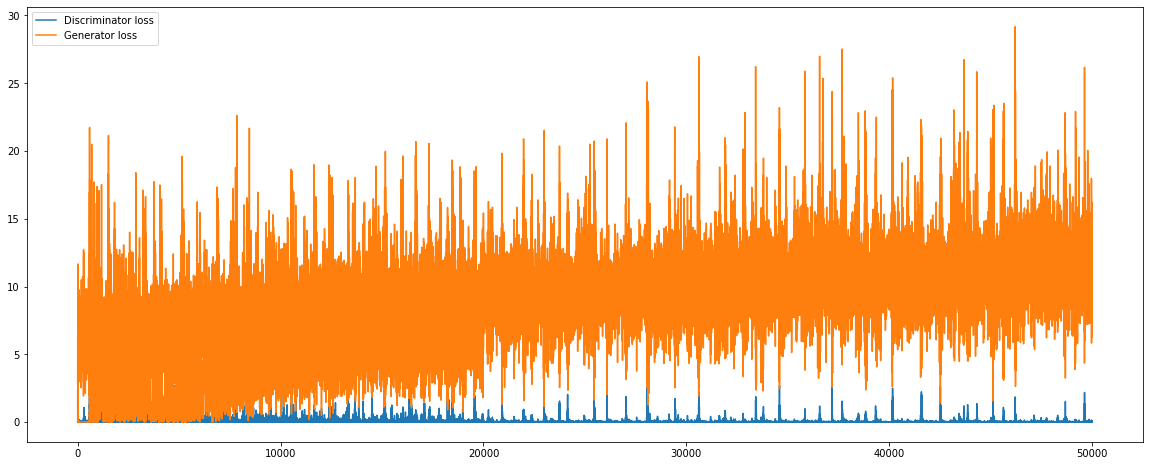

In [20]:
d_loss = [loss[0] for loss in losses]
g_loss = [loss[1] for loss in losses]

plt.figure(figsize=(20,8))
plt.plot(iteration_checkpoints, d_loss, label='Discriminator loss')
plt.plot(iteration_checkpoints, g_loss, label='Generator loss')
plt.legend()

## Samples after 50K iterations

How it looks at 1x Zoom level 

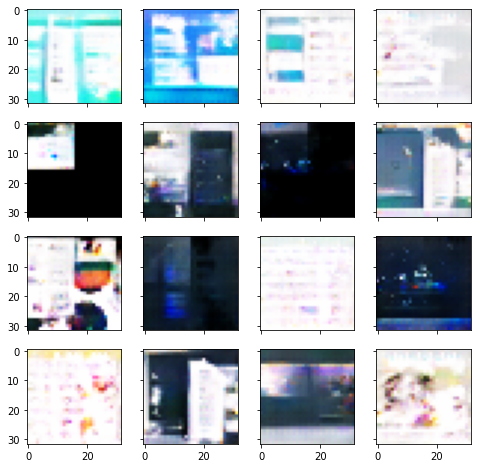

In [21]:
sample_digits(generator,num_rows=4, num_cols=4, zoom_level=2)

How it looks at 1.5x zoom level

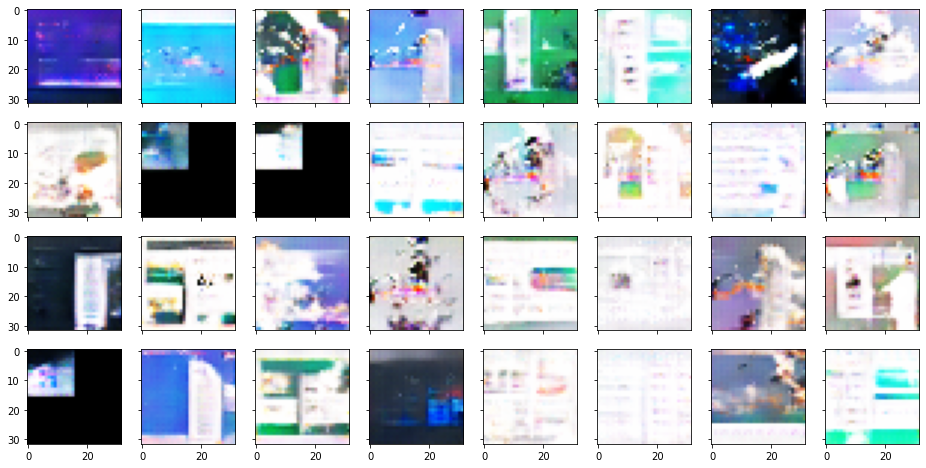

In [22]:
sample_digits(generator,num_rows=4, num_cols=8, zoom_level=2)

### Observations
The basic DCGAN of size 32x32 seems to pick up important cues from the dataset after 20K iterations.

A few noticable traits of generated images are:
- Screens are light in colour
- Placing designs on colourful backgrounds with shadow effect
- It seems to pick up UI items like buttons and images and columns but it is not clearly noticable at this resolution.

### Next Steps
- Experiment with a bigger DCGAN model (64x64)
- Try training a Progressive GAN upto 64x64 or 128x128. 
- Gather more data